In [ ]:
import pandas as pd
import numpy as np
import spacy   # another tokenizer, lemmatizer (has --> be)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#movie_df = pd.read_csv('drive/MyDrive/shortened_movies.csv')
movie_df = pd.read_csv('shortened_movies.csv')
#print(movie_df.columns)
print(movie_df.shape)

(1559, 4)


In [ ]:
choose_genres = ['romantic comedy','action']
select_movies = movie_df[['Title','Plot', 'Genre']][movie_df['Genre'].isin(choose_genres)]
print(select_movies.shape)
#print(select_movies[:3])

(1559, 3)


In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('parser', 'ner') 

['parser', 'ner']

In [ ]:
def nlp_processing(doc): # from indexing.ipyns
  nlp.max_length = len(doc)
  tokens = nlp(doc)
    
  #eliminates stop words  and non alpha num
  terms = [token for token in tokens if not token.is_stop and token.is_alpha]

  start_prop_noun = False
  words_spacy = []
  for t in terms:
    if t.pos_ == "PROPN":
      if not start_prop_noun:
        start_prop_noun = True
        prop_noun = t.text.lower()
      else:
        prop_noun += ' ' + t.text.lower()
    elif start_prop_noun:
      start_prop_noun = False
      words_spacy.append(prop_noun)
      prop_noun = ""
        
    if not start_prop_noun:
      words_spacy.append(t.lemma_.lower())
  
  return words_spacy

In [ ]:
vect = CountVectorizer(tokenizer = nlp_processing, min_df = 8)

counter = vect.fit_transform(select_movies['Plot'])  # matrix representation of each movie as a tf-idf vector


print(len(vect.get_feature_names_out()))
#print(vect.get_feature_names_out()[:100])
#print(vect.get_feature_names_out()[-20:])

3626


In [ ]:
transf  = TfidfTransformer(sublinear_tf = True)
tf_idf = transf.fit_transform(counter) 
print(tf_idf.shape[0])
print(tf_idf.shape[1])

1559
3626


In [ ]:
def counter_func(items):
  sort_items = sorted(items) # sorts tokens alphabetically
  count_items = {}
  for item in sort_items:
    if item in count_items.keys():
      count_items[item] += 1
    else:
      count_items[item] = 1
  
  # sort by the count, in reverse order
  sorted_count_list = sorted(count_items.items(), 
                            key = lambda x:x[1], reverse = True)
  sorted_count_dict = dict(sorted_count_list)
  return sorted_count_dict

In [ ]:
def tf_idf_func(query, vocabulary):
  #Process the query and get term frequency count
  print("Query: \"" + query + "\"")
  tokens = nlp_processing(query)
  tf_query = counter_func(tokens)
  
  sim_query_doc = {} #{doc_id: similarity function results}
  #For each query term
  for (term_q,tf_term_q) in tf_query.items():
    #print("query term:",term_q,"\tfreq:",tf_term_q)
    #if query term is found in any document (dict_term_freq[term_q] will throw an error if query term is not in any document)
    if term_q in vocabulary:

      #get list of documents where tf-idf > 0 for this term
      tf_idf_scores_of_word = tf_idf[:,np.where(vocabulary == term_q)[0][0]]
      #docs = tf_idf_scores_of_word > 0

      #for each document the query term is found in (can skip if not found in document b/c portion of summation will = 0)
      for doc in tf_idf_scores_of_word.nonzero()[0]:
        #If doc found, add current term's results to previous term's results
        if doc in sim_query_doc:
          #tf_doc = tf_func(dict_term_freq[term_q][doc])
          #idf_doc = idf_func(n_docs, doc_freq[np.where(vocabulary == term_q)])
          sim_query_doc[doc] += float(tf_term_q * tf_idf_scores_of_word[doc,0])
        else:
          #tf_doc = tf_func(dict_term_freq[term_q][doc])
          #idf_doc = idf_func(n_docs, doc_freq[np.where(vocabulary == term_q)])
          sim_query_doc[doc] = float(tf_term_q * tf_idf_scores_of_word[doc,0])

  sorted_sim = dict(sorted(sim_query_doc.items(), key = lambda x: x[1], 
                    reverse = True))
  return sorted_sim

In [ ]:
#print(select_movies['Plot'].iloc[1])
vocab = vect.get_feature_names_out()

In [ ]:
#Rocchio Feedback
def rocchio_feedback(original_query, relevant_docs, nonrelevant_docs, alpha, beta, gamma):
  tf_idf_relevant = tf_idf[relevant_docs,:]
  tf_idf_nonrelevant = tf_idf[nonrelevant_docs,:]

  #print(tf_idf_relevant.shape)
  #print(tf_idf_nonrelevant.shape)

  #compute centroids
  # centroid_positive = [0] * tf_idf_relevant.shape[1]
  # for i in range(tf_idf_relevant.shape[0]):
  #   centroid_positive += tf_idf_relevant[i,:]
  if len(relevant_docs) > 0:
    centroid_positive = tf_idf_relevant.mean(0)
  else:
    #centroid_positive = np.array([0] * tf_idf.shape[1])
    centroid_positive = original_query

  if len(nonrelevant_docs) > 0: 
    centroid_negative = tf_idf_nonrelevant.mean(0)
  else:
    #centroid_negative = np.array([0] * tf_idf.shape[1])
    centroid_negative = original_query

  #print(type(centroid_positive))
  #print(type(centroid_negative))
  #print(len(centroid_positive))
  #print(centroid_negative.shape)

  #oq_array = original_query

  return alpha * original_query + beta * centroid_positive - gamma * centroid_negative

In [ ]:
def tf_idf_func_rocchio(query, new_rocchio_query, vocabulary):
  #Process the query and get term frequency count
  print("Query: \"" + query + "\"")
  tokens = nlp_processing(query)
  tf_query = counter_func(tokens)
  
  sim_query_doc = {} #{doc_id: similarity function results}
  #For each query term
  for term_id in new_rocchio_query.nonzero()[1]:
    #print("query term:",term_q,"\tfreq:",tf_term_q)
    #if query term is found in any document (dict_term_freq[term_q] will throw an error if query term is not in any document)
    #if term_q in vocabulary:

    #get list of documents where tf-idf > 0 for this term
    tf_idf_scores_of_word = tf_idf[:,term_id]
    #docs = tf_idf_scores_of_word > 0

    #for each document the query term is found in (can skip if not found in document b/c portion of summation will = 0)
    for doc in tf_idf_scores_of_word.nonzero()[0]:
      #If doc found, add current term's results to previous term's results
      if doc in sim_query_doc:
        #tf_doc = tf_func(dict_term_freq[term_q][doc])
        #idf_doc = idf_func(n_docs, doc_freq[np.where(vocabulary == term_q)])
        sim_query_doc[doc] += float(new_rocchio_query[0,term_id] * tf_idf_scores_of_word[doc,0])
      else:
        #tf_doc = tf_func(dict_term_freq[term_q][doc])
        #idf_doc = idf_func(n_docs, doc_freq[np.where(vocabulary == term_q)])
        sim_query_doc[doc] = float(new_rocchio_query[0,term_id] * tf_idf_scores_of_word[doc,0])

  sorted_sim = dict(sorted(sim_query_doc.items(), key = lambda x: x[1], 
                    reverse = True))
  return sorted_sim

In [ ]:
# sorted_sim = tf_idf_func_rocchio("coward criminal arrested", rocchio_query, vocab)
# print("TF-IDF:")
# [print(str(doc_id) + ": " + select_movies['Plot'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

search_query = "coward criminal arrested"

sorted_sim = tf_idf_func(search_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

query_counter = vect.transform([search_query])
query_tf_idf = transf.transform(query_counter)
rocchio_query = rocchio_feedback(query_tf_idf, [1028,1145,1084,1436], [861,1061,423,1031,903,272], .7, .2, .1)

sorted_sim = tf_idf_func_rocchio(search_query, rocchio_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

Query: "coward criminal arrested"
TF-IDF:
861: The Long Duel:	0.3782154630359088
1028: Aakhri Adaalat:	0.31750993214977663
1145: Deadly Soma:	0.31268971344687024
1084: Judge Mujrim:	0.282714355302558
1061: Pardesi:	0.27732632395300233
1436: Ek Niranjan:	0.2768002767177371
423: Extreme Justice:	0.26789795999234806
1031: Paap Ki Duniya:	0.243679772448755
903: The Fast Sword:	0.24012357732339118
272: Walking the Edge:	0.23825499812405299
Query: "coward criminal arrested"
TF-IDF:
1145: Deadly Soma:	0.14786128659376355
1028: Aakhri Adaalat:	0.1465893189777554
1436: Ek Niranjan:	0.13311442735428977
1084: Judge Mujrim:	0.13215224610340853
861: The Long Duel:	0.10022566154135575
1095: Arjun Pandit:	0.09358792390375595
1061: Pardesi:	0.08650791010002071
1128: Singham:	0.08557487435930877
1047: Prahaar: The Final Attack:	0.07482208600288279
1015: Aamne Samne:	0.0723559971737122


[None, None, None, None, None, None, None, None, None, None]

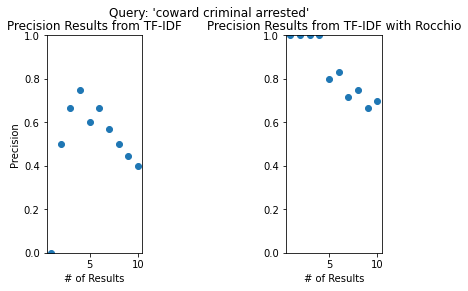

In [ ]:
x = range(1,11)
y1 = [0/1,1/2,2/3,3/4,3/5,4/6,4/7,4/8,4/9,4/10]
y2 = [1/1,2/2,3/3,4/4,4/5,5/6,5/7,6/8,6/9,7/10]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x,y1)
ax1.set_title('Precision Results from TF-IDF')
ax1.set(xlabel='# of Results', ylabel='Precision')
ax1.set_ylim([0,1])
ax2.scatter(x,y2)
ax2.set_title('Precision Results from TF-IDF with Rocchio')
ax2.set(xlabel='# of Results')
ax2.set_ylim([0,1])
fig.suptitle("Query: 'coward criminal arrested'")
plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
sorted_sim = tf_idf_func("christmas action movie", vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

query_counter = vect.transform(["christmas action movie"])
query_tf_idf = transf.transform(query_counter)
rocchio_query = rocchio_feedback(query_tf_idf, [], [1160,1072,1090,1104,1012,1159,1087,1064,1158,1099], .7, .2, .1)

sorted_sim = tf_idf_func_rocchio("christmas action movie", rocchio_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

Query: "christmas action movie"
TF-IDF:
1160: Kote:	0.5676069615133247
1072: Jurmana:	0.5496731090190631
1090: Devta:	0.5276071503584914
1104: Sanyasi Mera Naam:	0.5276071503584914
1012: Ghamandee:	0.4865362300135259
1159: Kanteerava:	0.4113141992036755
1087: Suraj:	0.3892554662694855
1064: Kranti Kshetra:	0.3521787454031901
1158: Boss:	0.3289581371849738
1099: Kahani Kismat Ki:	0.32666934741601517
Query: "christmas action movie"
TF-IDF:
1160: Kote:	0.20849813456252264
1072: Jurmana:	0.20744678816732418
1090: Devta:	0.18692906666334697
1104: Sanyasi Mera Naam:	0.18692906666334697
1012: Ghamandee:	0.18339391662656987
674: Four Christmases:	0.153864983374774
1087: Suraj:	0.14508712637791338
1159: Kanteerava:	0.1428574326143883
1064: Kranti Kshetra:	0.13038971788079168
700: The Expendables:	0.12416789727206934


[None, None, None, None, None, None, None, None, None, None]

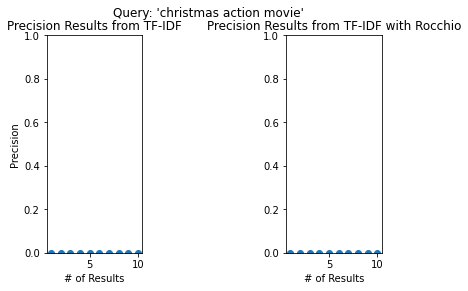

In [ ]:
x = range(1,11)
y1 = [0/1,0/2,0/3,0/4,0/5,0/6,0/7,0/8,0/9,0/10]
y2 = [0/1,0/2,0/3,0/4,0/5,0/6,0/7,0/8,0/9,0/10]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x,y1)
ax1.set_title('Precision Results from TF-IDF')
ax1.set(xlabel='# of Results', ylabel='Precision')
ax1.set_ylim([0,1])
ax2.scatter(x,y2)
ax2.set_title('Precision Results from TF-IDF with Rocchio')
ax2.set(xlabel='# of Results')
ax2.set_ylim([0,1])
fig.suptitle("Query: 'christmas action movie'")
plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
search_query = "love at first sight"

sorted_sim = tf_idf_func(search_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

query_counter = vect.transform([search_query])
query_tf_idf = transf.transform(query_counter)
rocchio_query = rocchio_feedback(query_tf_idf, [1417,1313,195], [1160,1072,1221,1200,1159,1512,1196], .7, .2, .1)

sorted_sim = tf_idf_func_rocchio(search_query, rocchio_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

Query: "love at first sight"
TF-IDF:
1417: Sri:	0.3333339525037201
1160: Kote:	0.33149149517891224
1072: Jurmana:	0.29807336837350096
1313: Kandaen:	0.29221624901121324
195: Minnie and Moskowitz:	0.24737100532626424
1221: Mundeyan Ton Bachke Rahin:	0.24723976714792295
1200: Sringara Velan:	0.24245970909506814
1159: Kanteerava:	0.24021403563977
1512: Winner:	0.20547471602983247
1196: Navagatharkku Swagatham (നവാഗതർക്കു് സ്വാഗതം):	0.20045421504911304
Query: "love at first sight"
TF-IDF:
1417: Sri:	0.24586583952896815
1313: Kandaen:	0.22223735798286143
195: Minnie and Moskowitz:	0.1307094736373176
1200: Sringara Velan:	0.10972395385896756
549: Passport to Paris:	0.10775883021667942
1279: Malaikottai:	0.09901987779011709
1423: Bhayya:	0.09901987779011709
1466: Nuvva Nena:	0.09651419038387071
1498: Jil:	0.09511477231089961
1317: Raa Raa:	0.09205015335553016


[None, None, None, None, None, None, None, None, None, None]

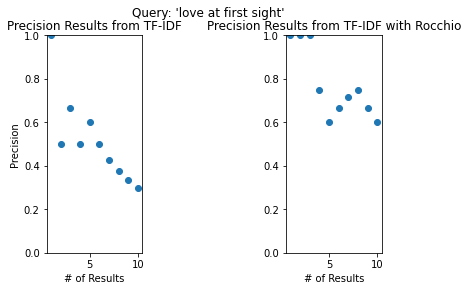

In [ ]:
x = range(1,11)
y1 = [1/1,1/2,2/3,2/4,3/5,3/6,3/7,3/8,3/9,3/10]
y2 = [1/1,2/2,3/3,3/4,3/5,4/6,5/7,6/8,6/9,6/10]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x,y1)
ax1.set_title('Precision Results from TF-IDF')
ax1.set(xlabel='# of Results', ylabel='Precision')
ax1.set_ylim([0,1])
ax2.scatter(x,y2)
ax2.set_title('Precision Results from TF-IDF with Rocchio')
ax2.set(xlabel='# of Results')
ax2.set_ylim([0,1])
fig.suptitle("Query: 'love at first sight'")
plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
search_query = "finding a missing person"

sorted_sim = tf_idf_func(search_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

query_counter = vect.transform([search_query])
query_tf_idf = transf.transform(query_counter)
rocchio_query = rocchio_feedback(query_tf_idf, [1032,1029], [1470,856,1044,302,69,715,1427,488], .7, .2, .1)

sorted_sim = tf_idf_func_rocchio(search_query, rocchio_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

Query: "finding a missing person"
TF-IDF:
1470: Srimannarayana:	0.3114229672509513
856: Our Man in the Caribbean:	0.24935144803184112
1032: Saazish:	0.23740001753060283
1044: Farishtay:	0.21780834926828035
1029: Jeete Hain Shaan Se:	0.21633141125516728
302: Armed Response:	0.20986862646465068
69: Dancing Co-Ed:	0.20741293159550578
715: The Switch:	0.20512687148767136
1427: Okka Magadu:	0.2015321986140492
488: One Fine Day:	0.19862154821413502
Query: "finding a missing person"
TF-IDF:
1032: Saazish:	0.19464783715102968
1029: Jeete Hain Shaan Se:	0.18015228712844805
1470: Srimannarayana:	0.12324706746390866
856: Our Man in the Caribbean:	0.11244575767701555
1134: Enemmy:	0.08996656444716841
728: No Strings Attached:	0.08937905996355844
1500: Malupu:	0.08494439353739512
1519: Paisa Vasool:	0.08356492310638891
1008: Do Shikaari:	0.08309204674798659
715: The Switch:	0.08240948021035308


[None, None, None, None, None, None, None, None, None, None]

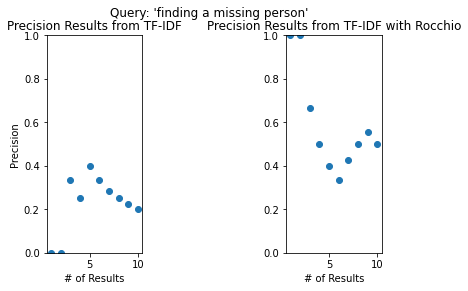

In [ ]:
x = range(1,11)
y1 = [0/1,0/2,1/3,1/4,2/5,2/6,2/7,2/8,2/9,2/10]
y2 = [1/1,2/2,2/3,2/4,2/5,2/6,3/7,4/8,5/9,5/10]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x,y1)
ax1.set_title('Precision Results from TF-IDF')
ax1.set(xlabel='# of Results', ylabel='Precision')
ax1.set_ylim([0,1])
ax2.scatter(x,y2)
ax2.set_title('Precision Results from TF-IDF with Rocchio')
ax2.set(xlabel='# of Results')
ax2.set_ylim([0,1])
fig.suptitle("Query: 'finding a missing person'")
plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
search_query = "Remarry after relationship ended"

sorted_sim = tf_idf_func(search_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

query_counter = vect.transform([search_query])
query_tf_idf = transf.transform(query_counter)
rocchio_query = rocchio_feedback(query_tf_idf, [262,1097,883,962,1201,773,381,893], [301,603], .7, .2, .1)

sorted_sim = tf_idf_func_rocchio(search_query, rocchio_query, vocab)
print("TF-IDF:")
[print(str(doc_id) + ": " + select_movies['Title'].iloc[doc_id] + ":\t" + str(value)) for (doc_id,value) in list(sorted_sim.items())[:10]]

Query: "Remarry after relationship ended"
TF-IDF:
262: Kiss Me Goodbye:	0.31403939033882355
1097: Gair:	0.2852647597004154
301: About Last Night...:	0.260028022091267
883: The Republic of Love:	0.22531280081371022
962: Always Be My Maybe:	0.22139327159657105
1201: Pattam Pole:	0.21665105760504566
773: That Awkward Moment:	0.21633667516357666
603: Something's Gotta Give:	0.21594891337733882
381: Funny About Love:	0.20348845651629816
893: Call for Love:	0.19619292578445433
Query: "Remarry after relationship ended"
TF-IDF:
1097: Gair:	0.2045259621276764
262: Kiss Me Goodbye:	0.18506961226884744
172: Marriage on the Rocks:	0.10553000145489981
883: The Republic of Love:	0.09884615380682041
837: The Farmer's Wife:	0.09300644568279413
294: Missing in Action 2: The Beginning:	0.09003818610546203
381: Funny About Love:	0.08830186651852238
962: Always Be My Maybe:	0.08689739265687424
773: That Awkward Moment:	0.08630550846083346
181: Hellfighters:	0.08530915726483726


[None, None, None, None, None, None, None, None, None, None]

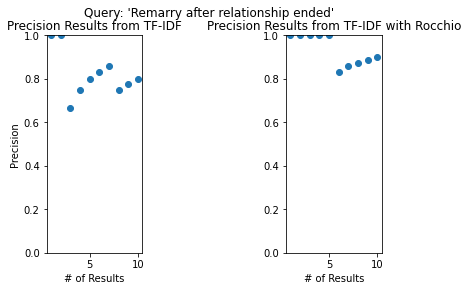

In [ ]:
x = range(1,11)
y1 = [1/1,2/2,2/3,3/4,4/5,5/6,6/7,6/8,7/9,8/10]
y2 = [1/1,2/2,3/3,4/4,5/5,5/6,6/7,7/8,8/9,9/10]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x,y1)
ax1.set_title('Precision Results from TF-IDF')
ax1.set(xlabel='# of Results', ylabel='Precision')
ax1.set_ylim([0,1])
ax2.scatter(x,y2)
ax2.set_title('Precision Results from TF-IDF with Rocchio')
ax2.set(xlabel='# of Results')
ax2.set_ylim([0,1])
fig.suptitle("Query: 'Remarry after relationship ended'")
plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
precision_before_feedback_5 = np.array([3/5,0/5,3/5,2/5,4/5])
precision_before_feedback_10 = np.array([4/10,0/10,3/10,2/10,8/10])
precision_after_feedback_5 = np.array([4/5,0/5,3/5,2/5,5/5])
precision_after_feedback_10 = np.array([7/10,0/10,6/10,5/10,10/10])

print('Average Precision of Top 5 Results before feedback:',precision_before_feedback_5.mean())
print('Average Precision of Top 10 Results before feedback:',precision_before_feedback_10.mean())
print('Average Precision of Top 5 Results after feedback:',precision_after_feedback_5.mean())
print('Average Precision of Top 10 Results after feedback:',precision_after_feedback_10.mean())
print('Precision Standard Deviation of Top 5 Results before feedback:',precision_before_feedback_5.std())
print('Precision Standard Deviation of Top 10 Results before feedback:',precision_before_feedback_10.std())
print('Precision Standard Deviation of Top 5 Results after feedback:',precision_after_feedback_5.std())
print('Precision Standard Deviation of Top 10 Results after feedback:',precision_after_feedback_10.std())

Average Precision of Top 5 Results before feedback: 0.4800000000000001
Average Precision of Top 10 Results before feedback: 0.33999999999999997
Average Precision of Top 5 Results after feedback: 0.5599999999999999
Average Precision of Top 10 Results after feedback: 0.5599999999999999
Precision Standard Deviation of Top 5 Results before feedback: 0.2712931993250107
Precision Standard Deviation of Top 10 Results before feedback: 0.265329983228432
Precision Standard Deviation of Top 5 Results after feedback: 0.34409301068170506
Precision Standard Deviation of Top 10 Results after feedback: 0.32619012860600183
